In [1]:
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM

# Data

## Concat Data

In [2]:
train_dataframes = []

for i in range(2, 11):
    data = loadarff('Brazilian Dataset/base_desenv_{0:02d}.arff'.format(i))
    df = pd.DataFrame(data[0])
    train_dataframes.append(df)

test_dataframes = []

for i in range(2,11):
    data = loadarff('Brazilian Dataset/base_validacao_{0:02d}.arff'.format(i))
    df = pd.DataFrame(data[0])
    test_dataframes.append(df)

In [3]:
concatenated_df = pd.concat(train_dataframes)
concatenated_df = concatenated_df.dropna()
concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df['flag_fraude_cat'] = concatenated_df['flag_fraude_cat'].map({b'N': 0, b'S': 1})
train_df = concatenated_df

In [4]:
concatenated_df = pd.concat(test_dataframes)
concatenated_df = concatenated_df.dropna()
concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df['flag_fraude_cat'] = concatenated_df['flag_fraude_cat'].map({b'N': 0, b'S': 1})
test_df = concatenated_df

In [5]:
train_df.describe()

,mcc_cat,mcc_ant_cat,cep_cat,cep_ant_cat,valor_trans_cat,valor_trans_ant_cat,pos_entry,lim_cred_cat,bandeira_cat,variante_cat,score_cat,tp_pessoa_cat,trans_nacional_cat,qtde_parc_cat,velocidade_cat,dif_score_cat,trans_limit_cat,flag_fraude_cat
count,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000,262106.000000
mean,10.905428,6.620898,3.905870,2.289803,4.993651,3.360843,3.834746,5.891468,2.349702,2.015616,0.628749,0.983159,0.004952,1.210983,3.366027,2.932947,0.070319,0.037546
std,6.260796,7.290510,2.442473,2.650400,2.434455,2.712890,3.160117,2.432462,1.717889,0.834856,1.701864,0.128674,0.070198,0.467769,1.708333,0.984337,0.401096,0.190096
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,6.000000,0.000000,2.000000,0.000000,3.000000,1.000000,2.000000,4.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,2.000000,3.000000,0.000000,0.000000
50%,9.000000,6.000000,4.000000,1.000000,5.000000,2.000000,2.000000,6.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000,2.000000,3.000000,0.000000,0.000000
75%,15.000000,12.000000,6.000000,4.000000,7.000000,5.000000,9.000000,8.000000,5.000000,3.000000,0.000000,1.000000,0.000000,1.000000,5.000000,3.000000,0.000000,0.000000
max,32.000000,32.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,5.000000,5.000000,9.000000,1.000000,1.000000,3.000000,7.000000,5.000000,9.000000,1.000000


In [6]:
test_df

,mcc_cat,mcc_ant_cat,cep_cat,cep_ant_cat,valor_trans_cat,valor_trans_ant_cat,pos_entry,lim_cred_cat,bandeira_cat,variante_cat,score_cat,tp_pessoa_cat,trans_nacional_cat,qtde_parc_cat,velocidade_cat,dif_score_cat,trans_limit_cat,flag_fraude_cat
0,22.0,0.0,3.0,0.0,6.0,1.0,2.0,6.0,2.0,3.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0,0
1,22.0,9.0,3.0,3.0,7.0,6.0,2.0,6.0,2.0,3.0,0.0,1.0,0.0,1.0,6.0,4.0,0.0,0
2,6.0,6.0,2.0,2.0,7.0,9.0,2.0,7.0,2.0,3.0,1.0,1.0,0.0,1.0,4.0,3.0,0.0,0
3,6.0,0.0,3.0,0.0,8.0,1.0,2.0,9.0,2.0,3.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0,0
4,13.0,0.0,7.0,0.0,3.0,1.0,2.0,8.0,2.0,3.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112712,8.0,15.0,6.0,6.0,6.0,2.0,2.0,3.0,4.0,1.0,0.0,1.0,0.0,1.0,5.0,3.0,0.0,0
112713,6.0,6.0,1.0,1.0,2.0,2.0,2.0,1.0,4.0,1.0,0.0,1.0,0.0,1.0,5.0,3.0,0.0,0
112714,3.0,0.0,5.0,0.0,4.0,1.0,2.0,1.0,4.0,1.0,0.0,1.0,0.0,2.0,2.0,3.0,0.0,0
112715,7.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,4.0,1.0,0.0,1.0,0.0,1.0,2.0,3.0,0.0,0


<Axes: >

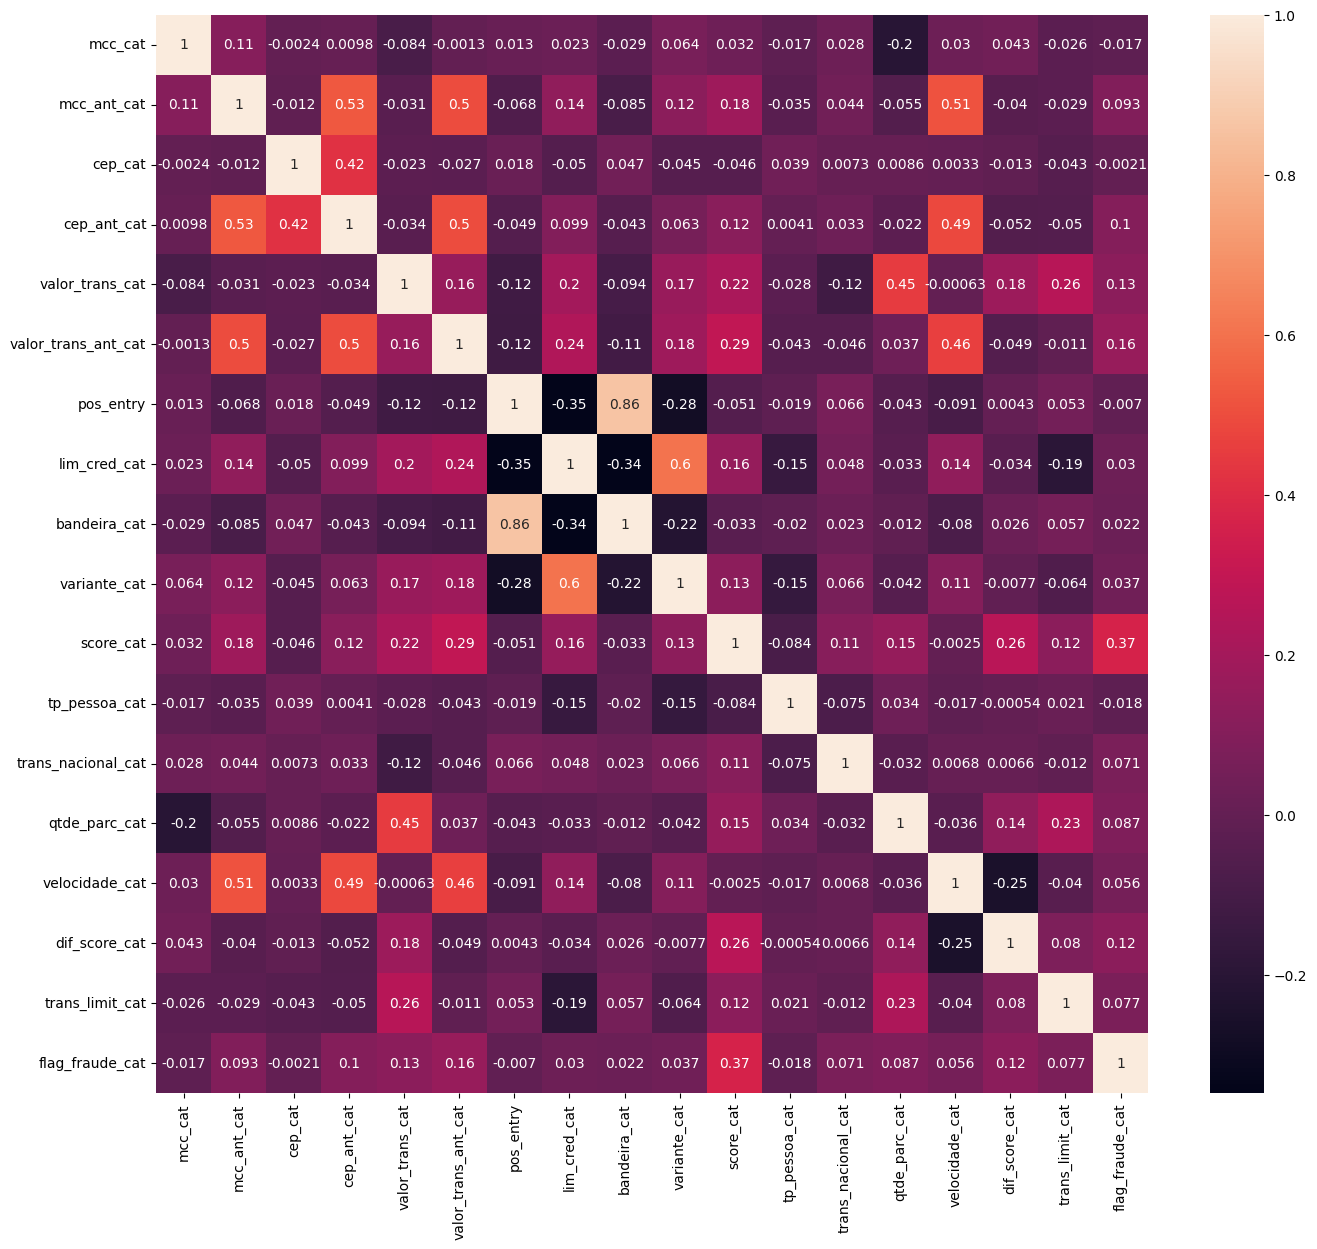

In [7]:
correlation_matrix = train_df.corr()
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True)

## Feature Reduction

In [8]:
from sklearn.feature_selection import VarianceThreshold

threshold = 0.1
selector = VarianceThreshold(threshold=threshold)
selector.fit(train_df)
selected_features = train_df.columns[selector.get_support()]

removed_features = train_df.columns[~selector.get_support()]
print("Removed Features:")
print(removed_features)

Removed Features:
Index(['tp_pessoa_cat', 'trans_nacional_cat', 'flag_fraude_cat'], dtype='object')


In [9]:
train_selected = train_df.drop(
    ['bandeira_cat', 'trans_nacional_cat', 'tp_pessoa_cat'], axis=1)
test_selected = test_df.drop(
    ['bandeira_cat', 'trans_nacional_cat', 'tp_pessoa_cat'], axis=1)

## Balance Data

In [10]:
X_train = train_df.drop('flag_fraude_cat', axis=1)
y_train = train_df['flag_fraude_cat']

X_train_selected = train_selected.drop('flag_fraude_cat', axis=1)

X_test = test_df.drop('flag_fraude_cat', axis=1)
y_test = test_df['flag_fraude_cat']

X_test_selected = test_selected.drop('flag_fraude_cat', axis=1)

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
X_train_selected_balanced, y_train_selected_balanced = smote.fit_resample(X_train_selected, y_train)

## Normalize Data

In [11]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_balanced_normalized = scaler.fit_transform(X_train_balanced)

X_train_selected_balanced_normalized = scaler.fit_transform(X_train_selected_balanced)
X_test_selected_normalized = scaler.transform(X_test_selected)

# Time Series

## Prepare Data

In [12]:
def create_dataset(X, y, lookback):
    X_res, y_res = [], []
    for i in range(len(X)-lookback-1):
        feature = X[i: i+lookback]
        target = y[i+lookback+1]
        X_res.append(feature)
        y_res.append(target)
    return torch.tensor(X_res), torch.tensor(y_res)

In [13]:
lookback = 5
X_train_series, y_train_series = create_dataset(X_train_normalized, y_train, lookback)
X_test_series, y_test_series = create_dataset(X_test_normalized, y_test, lookback)

/var/folders/kt/nq6zgw490ss19zjf68kmbl580000gn/T/ipykernel_8594/1589454143.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699448803473/work/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.tensor(X_res), torch.tensor(y_res)


In [14]:
def report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot()
    plt.show()

## LSTM

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, lookback):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(hidden_size * lookback, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.flatten(out)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out

In [16]:
model = LSTMModel(input_size=17, hidden_size=50, num_layers=2, lookback=lookback)
device = torch.device('mps')

model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)

inputs_tensor = torch.tensor(X_train_series).float()
targets_tensor = torch.tensor(y_train_series).float()

test_inputs_tensor = torch.tensor(X_test_series).float()
test_targets_tensor = torch.tensor(y_test_series).float()

train_dataset = TensorDataset(inputs_tensor, targets_tensor)

test_dataset = TensorDataset(test_inputs_tensor, test_targets_tensor)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 20
for epoch in range(num_epochs):
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs.squeeze(), targets)

        loss.backward()
        optimizer.step()
        
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.squeeze()
            predicted = (outputs > 0.5).float()
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    print('Epoch [{}/{}], Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
        epoch + 1, num_epochs, loss.item(), 100 * correct / total))

/var/folders/kt/nq6zgw490ss19zjf68kmbl580000gn/T/ipykernel_8594/3161781030.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_tensor = torch.tensor(X_train_series).float()
/var/folders/kt/nq6zgw490ss19zjf68kmbl580000gn/T/ipykernel_8594/3161781030.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_tensor = torch.tensor(y_train_series).float()
/var/folders/kt/nq6zgw490ss19zjf68kmbl580000gn/T/ipykernel_8594/3161781030.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_inputs_tensor = torch.tensor(X_test_series).float

Epoch [1/20], Loss: 0.0225, Test Accuracy: 96.25%
Epoch [2/20], Loss: 0.0221, Test Accuracy: 96.25%
Epoch [3/20], Loss: 0.0222, Test Accuracy: 96.25%
Epoch [4/20], Loss: 0.0218, Test Accuracy: 96.27%
Epoch [5/20], Loss: 0.0207, Test Accuracy: 96.29%
Epoch [6/20], Loss: 0.0192, Test Accuracy: 96.31%
Epoch [7/20], Loss: 0.0175, Test Accuracy: 96.32%
Epoch [8/20], Loss: 0.0159, Test Accuracy: 96.33%
Epoch [9/20], Loss: 0.0145, Test Accuracy: 96.35%
Epoch [10/20], Loss: 0.0133, Test Accuracy: 96.39%
Epoch [11/20], Loss: 0.0125, Test Accuracy: 96.43%
Epoch [12/20], Loss: 0.0119, Test Accuracy: 96.47%
Epoch [13/20], Loss: 0.0115, Test Accuracy: 96.48%
Epoch [14/20], Loss: 0.0113, Test Accuracy: 96.52%
Epoch [15/20], Loss: 0.0112, Test Accuracy: 96.55%
Epoch [16/20], Loss: 0.0114, Test Accuracy: 96.58%
Epoch [17/20], Loss: 0.0116, Test Accuracy: 96.62%
Epoch [18/20], Loss: 0.0121, Test Accuracy: 96.66%
Epoch [19/20], Loss: 0.0126, Test Accuracy: 96.68%
Epoch [20/20], Loss: 0.0133, Test Accura

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98    108521
         1.0       0.31      0.07      0.11      4190

    accuracy                           0.96    112711
   macro avg       0.64      0.53      0.54    112711
weighted avg       0.94      0.96      0.95    112711



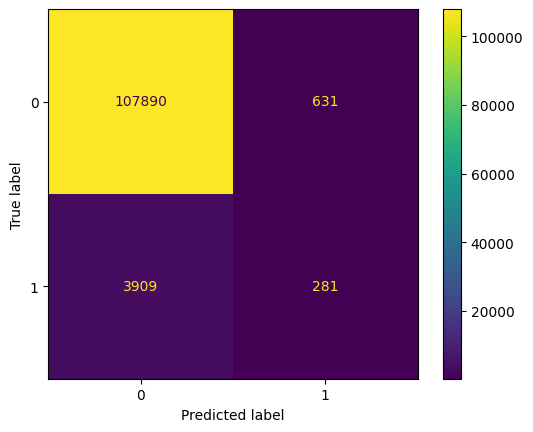

In [17]:
model.eval()

predicted_labels = []
true_labels = []

for inputs, targets in test_dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    
    outputs = model(inputs)
    outputs = outputs.squeeze()
    
    predicted = (outputs > 0.5).float()
    
    predicted_labels.extend(predicted.cpu().numpy())
    true_labels.extend(targets.cpu().numpy())

predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

report(true_labels, predicted_labels)

# Outlier Detection

## LOF

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95    252265
           1       0.03      0.04      0.03      9841

    accuracy                           0.90    262106
   macro avg       0.49      0.49      0.49    262106
weighted avg       0.93      0.90      0.91    262106



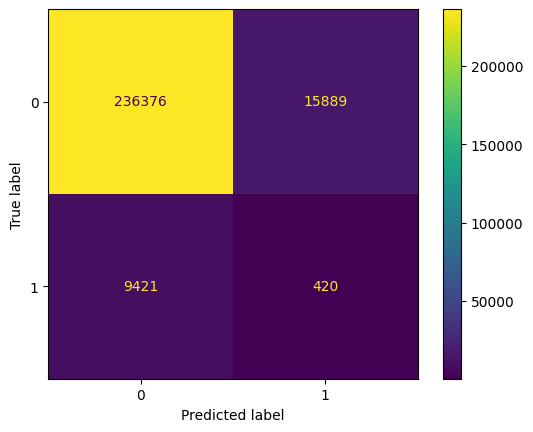

In [16]:
lof = LocalOutlierFactor()
lof.fit(X_train_normalized)
y_pred = lof.fit_predict(X_train_normalized)

y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]
report(y_train, y_pred_binary)

# Classic Algorithms

## Random Forest

/home/aref/pyenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/aref/pyenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/aref/pyenv/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/home/aref/pyenv/lib/python3.11/site-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/home/aref/pyenv/lib/python3.1

Best Parameters: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 64}
Best Score: 0.9889053988020386
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97    108527
           1       0.29      0.49      0.36      4190

    accuracy                           0.94    112717
   macro avg       0.63      0.72      0.67    112717
weighted avg       0.95      0.94      0.94    112717



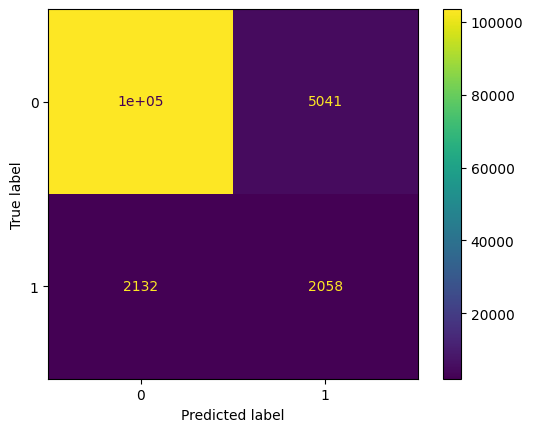

In [14]:
param_grid = {
    'n_estimators': [64, 72],
    'max_depth': [8, 16],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1 , 2 , 3]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_balanced_normalized, y_train_balanced)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_rf = RandomForestClassifier(**best_params)

best_rf.fit(X_train_balanced_normalized, y_train_balanced)

y_pred = best_rf.predict(X_test_normalized)

report(y_test, y_pred)

### Selected Features

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    108527
           1       0.88      0.97      0.92      4190

    accuracy                           0.99    112717
   macro avg       0.94      0.98      0.96    112717
weighted avg       0.99      0.99      0.99    112717



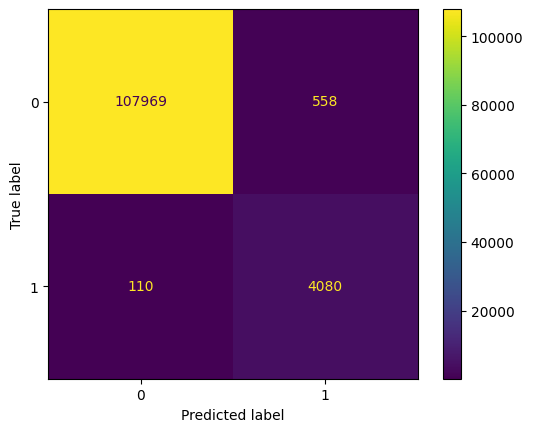

In [16]:
rf = RandomForestClassifier(max_depth=16, min_samples_leaf=1, min_samples_split=2, n_estimators=64)
rf.fit(X_train_selected_balanced_normalized, y_train_balanced)
y_pred = rf.predict(X_test_selected_normalized)

report(y_test, y_pred)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

param_grid = {
    'max_depth': [2, 4, 8],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid, scoring=make_scorer(f1_score, average='macro'), cv=5)
grid_search.fit(X_train_selected_balanced_normalized, y_train_balanced)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_dt = DecisionTreeClassifier(**best_params)
best_dt.fit(X_train_selected_balanced_normalized, y_train_balanced)
y_pred = best_dt.predict(X_test_selected_normalized)
report(y_test, y_pred)